## Telco Customer Churn Analysis
### 1. Import packages and merge dataset

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

sys.path.append("../src")
import utils

In [2]:
churn = pd.read_csv('../data/raw/customer-churn.csv')
customer = pd.read_csv('../data/raw/customer-data.csv')
service = pd.read_csv('../data/raw/service-subscription.csv')
print(f'Before merge: \n\t Churn data: {churn.shape}, \n\t customer data: {customer.shape}, \n\t service subscription: {service.shape}')

Before merge: 
	 Churn data: (7043, 8), 
	 customer data: (7043, 5), 
	 service subscription: (7043, 10)


In [ ]:
temp = pd.merge(churn, customer, how='inner', on="customerID")
df = pd.merge(temp, service, how='inner', on='customerID')
print(f'After merge: {df.shape}')
df.head()

In [ ]:
df.to_csv('../data/final/clean-telco-data.csv')

### 2. Data Preprocessing

In [3]:
df = pd.read_csv('../data/final/clean-telco-data.csv')

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], how='all', inplace=True)

utils.check_missing_data(df)

Unnamed: 0          0.0
customerID          0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
gender              0.0
Churn               0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
tenure              0.0
StreamingMovies     0.0
dtype: float64

In [5]:
label = LabelEncoder()
for cat_var in ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[cat_var] = label.fit_transform(df[cat_var])

df = pd.get_dummies(df, columns = ['Contract', 'PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], dtype=np.int64)


In [6]:
df.drop(['customerID', 'Contract_Two year', 'Unnamed: 0', 'PaymentMethod_Mailed check', 'MultipleLines_No', 'InternetService_No',
         'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No'], axis=1, inplace=True)
df.head()

,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,PhoneService,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,1,1,29.85,29.85,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,34,0,56.95,1889.50,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,2,1,53.85,108.15,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,45,0,42.30,1840.75,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,2,1,70.70,151.65,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y = df['Churn']
X_data = df[['MonthlyCharges', 'gender', 'Dependents', 'tenure', 'PhoneService', 'Contract_Month-to-month', 'Contract_One year', 
             'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check',
             'MultipleLines_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL',]]

x_train, x_, y_train, y_ = train_test_split(X_data, y, test_size=0.40, random_state=80)  # Get 60% of the dataset as the training set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)  # Split the 40% subset into cross validation and test

### 3. Base model

In [9]:
base_scaler = StandardScaler()
X_train_scaled = base_scaler.fit_transform(x_train)
X_cv_scaled = base_scaler.transform(x_cv)  # Scale the cross validation set
X_test_scaled = base_scaler.transform(x_test)

base_model = LogisticRegression()
base_model.fit(X_train_scaled, y_train)
yhat = base_model.predict(X_train_scaled)
yhat_test = base_model.predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Test MSE: {(mean_squared_error(y_test, yhat_test) / 2):.5f}")
print(f"Test set F1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Training MSE: 0.09919
Test MSE: 0.10554
Test set F1 score: 0.59147
Test set accuracy score: 0.53885


### 4. Handling imbalanced dataset to improve performance

In [20]:
X = pd.concat([x_train, y_train], axis=1)  # concat x train and y train
not_churn = X[X['Churn'] == 0]; churn = X[X['Churn'] == 1]  # separate minority and majority classes

# upsample minory
churn_upsampled = resample(churn, replace=True, # sample with replacement
                        n_samples=len(not_churn), # match number in majority class
                        random_state=27) # reproducible results

upsampled = pd.concat([not_churn, churn_upsampled])  # combine majority and upsampled minority
# X['Churn'].value_counts()  # before upsampling, check class counts
upsampled['Churn'].value_counts()   # after upsampling, check class counts

0    3116
1    3116
Name: Churn, dtype: int64

In [21]:
y_train = upsampled['Churn']
x_train = upsampled.drop('Churn', axis=1)

linear_scaler = StandardScaler()
X_train_scaled = linear_scaler.fit_transform(x_train)
X_cv_scaled = linear_scaler.transform(x_cv)  # Scale the cross validation set
X_test_scaled = linear_scaler.transform(x_test)

In [22]:
base_reviewed = LogisticRegression()
base_reviewed .fit(X_train_scaled, y_train)
yhat = base_reviewed .predict(X_train_scaled)
yhat_cv = base_reviewed .predict(X_cv_scaled)
yhat_test = base_reviewed .predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Cross validation MSE: {(mean_squared_error(y_cv, yhat_cv) / 2):.5f}")
print(f"Test set f1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Training MSE: 0.11305
Cross validation MSE: 0.14936
Test set f1 score: 0.63471
Test set accuracy score: 0.82957


### 5. Compare performance of different models

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression(),
    ]

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "F1", "Recall"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_scaled, y_train)
    name = clf.__class__.__name__
    
    # print(name)
    train_predictions = clf.predict(X_test_scaled)
    acc = f1_score(y_test, train_predictions)
    # print("F1: {:.4}".format(acc))
    
    ll = recall_score(y_test, train_predictions)
    # print("Recall: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="b", ax=ax[0])

ax[0].set_xlabel('F1')
ax[0].set_title('F1 Score')

# ax.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="g", ax=ax[1])
ax[1].set(ylabel=None)
ax[1].set_xlabel('Recall')
ax[1].set_title('Recall Score')

fig.suptitle('Classifers Performance')
plt.tight_layout()
plt.show()

### 6. Choose model with the best performance

In [28]:
best_model = GradientBoostingClassifier()
warnings.filterwarnings('ignore')
params = {
    'C': np.logspace(-3,3,7),
    'penalty': ['none','l2','l1'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'random_state': [12]
}

grid_bestm = GridSearchCV(base_model, param_grid=params, cv=5, scoring='f1').fit(X_train_scaled, y_train)
print('Best parameters:', grid_bestm.best_params_)
print('Best score:', grid_bestm.best_score_)

yhat = grid_bestm.predict(X_train_scaled)
yhat_test = grid_bestm.predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Cross validation MSE: {(mean_squared_error(y_cv, yhat_cv) / 2):.5f}")
print(f"Test set f1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Best parameters: {'C': 0.01, 'penalty': 'l1', 'random_state': 12, 'solver': 'saga'}
Best score: 0.7889179666475264
Training MSE: 0.11409
Cross validation MSE: 0.14936
Test set f1 score: 0.62100
Test set accuracy score: 0.85213


In [13]:
best_model = GradientBoostingClassifier().fit(X_train_scaled, y_train)
yhat = best_model.predict(X_train_scaled)
yhat_test = best_model.predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Cross validation MSE: {(mean_squared_error(y_cv, yhat_cv) / 2):.5f}")
print(f"Test set f1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Training MSE: 0.09933
Cross validation MSE: 0.13940
Test set f1 score: 0.65112
Test set accuracy score: 0.80451


### 7. ROC AUC and AUC of the best model

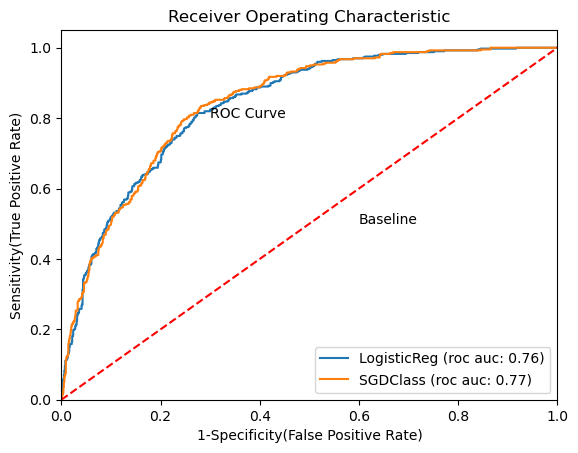

In [23]:
# Add the models to the list that you want to view on the ROC plot
models = [{'label': 'LogisticReg', 'model': base_model},
{'label': 'SGDClass', 'model': best_model}]
utils.plot_roc(models, X_test_scaled, y_test)

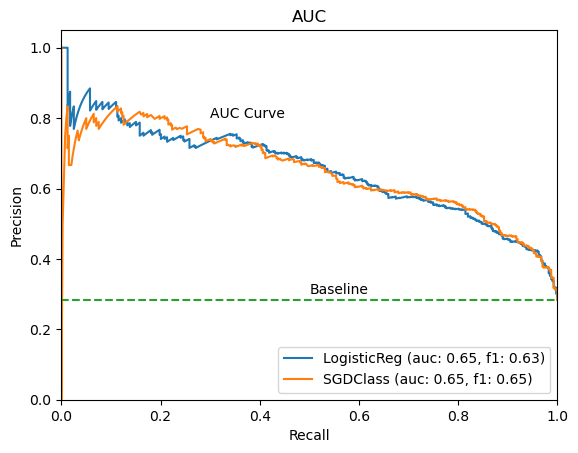

In [24]:
utils.plot_auc(models, X_test_scaled, y_test)